In [112]:
import matplotlib.pyplot as plt
import scienceplots


import numpy as np
import scipy.stats
import pandas as pd

import datetime

import sqlalchemy as sqla

In [2]:
plt.style.use(['science','no-latex'])

In [7]:
from scipy.stats import norm

In [116]:
rv = norm(loc=43200, scale=7200)

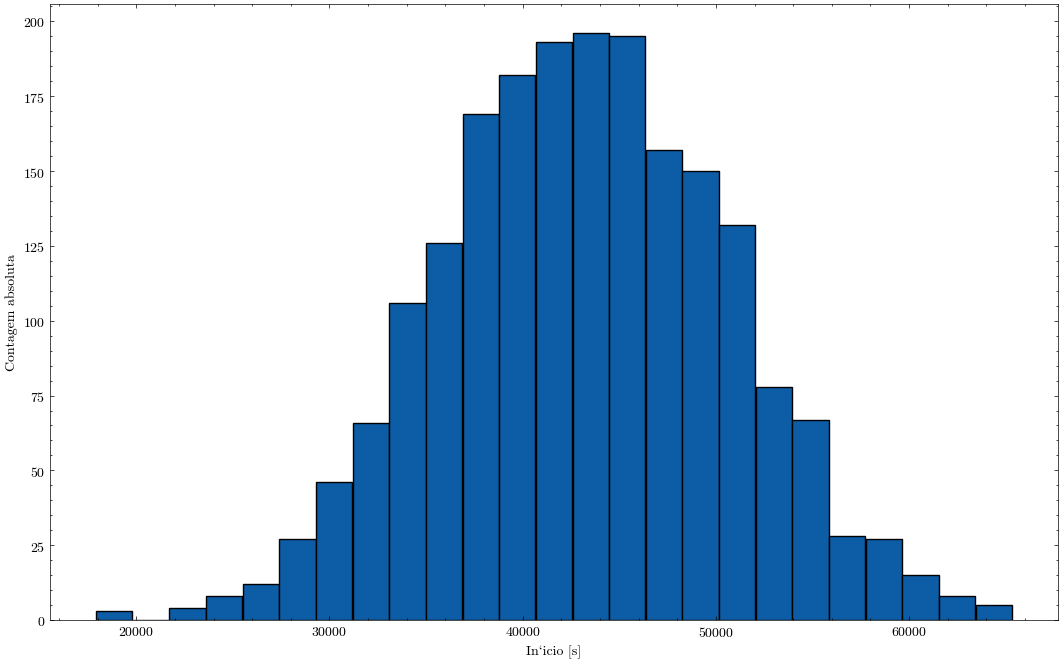

In [86]:
fig, ax = plt.subplots(figsize=(13,8))

ax.hist(rv.rvs(2000), bins=25, rwidth=0.99, edgecolor='black')
ax.set(xlabel='In`icio [s]', ylabel='Contagem absoluta')
plt.show()

# fig.savefig(bbox_inches='tight', fname='temp.pdf')

In [89]:
ids_jogadores = np.arange(1, 40000+1, dtype=int)

In [106]:
np.int32(np.floor(1e6))

1000000

In [156]:
data = datetime.datetime.fromisoformat('2025-02-24')
(data + datetime.timedelta(seconds=500)).isoformat(sep=' ')

'2025-02-24 00:08:20'

In [171]:
data = datetime.datetime.fromisoformat('2025-03-02')
data.weekday()


6

In [121]:
rv.rvs(1)[0]

42882.29313519225

In [146]:
(data + datetime.timedelta(seconds=rv.rvs(1)[0])).isoformat()

'2025-03-03T15:09:05.015171'

In [113]:
ids_jogadores_sessoes = np.random.choice(ids_jogadores, np.int32(np.floor(5000)))



In [295]:
ids_sessoes = np.arange(1,5000+1,dtype=np.int32)
so_sessoes = np.random.choice(['Windows', 'Mac', 'Linux'], p=[0.7, .25, .05], size=5000)
trilhas = np.random.choice(['Facil', 'Medio', 'Dificil'], p=[0.5, .3, .2], size=5000)
versoes = np.random.choice(['2.0.0', '2.1.0'], p=[0.9, .1], size=5000)
horarios = rv.rvs(5000)


In [297]:
dia = datetime.datetime.fromisoformat('2025-02-24')

In [298]:
arr=[]
for i in range(ids_sessoes.size):
    id_sessao = ids_sessoes[i]
    id_jogador = ids_jogadores_sessoes[i]
    so_sessao = so_sessoes[i]
    trilha = trilhas[i]
    versao_jogo = versoes[i]
    ts_criacao = dia + datetime.timedelta(seconds=horarios[i])
    arr.append([id_sessao, id_jogador, so_sessao, trilha, ts_criacao, versao_jogo])



In [299]:
df = pd.DataFrame(arr, columns=['id_sessao','id_jogador','so_sessao','trilha','ts_criacao','versao_jogo'])


In [313]:
df2=df.groupby([
    df['ts_criacao'].dt.floor('30min'),
    df['so_sessao'],
    df['trilha'],
    df['versao_jogo']
]).count()


In [329]:
df2.loc[:,'Windows',:,:]['id_sessao'].groupby(level=[0]).sum()

ts_criacao
2025-02-24 05:00:00      1
2025-02-24 06:00:00      4
2025-02-24 06:30:00      9
2025-02-24 07:00:00     18
2025-02-24 07:30:00     37
2025-02-24 08:00:00     72
2025-02-24 08:30:00    105
2025-02-24 09:00:00    114
2025-02-24 09:30:00    204
2025-02-24 10:00:00    251
2025-02-24 10:30:00    290
2025-02-24 11:00:00    328
2025-02-24 11:30:00    325
2025-02-24 12:00:00    345
2025-02-24 12:30:00    320
2025-02-24 13:00:00    300
2025-02-24 13:30:00    246
2025-02-24 14:00:00    209
2025-02-24 14:30:00    126
2025-02-24 15:00:00     83
2025-02-24 15:30:00     63
2025-02-24 16:00:00     29
2025-02-24 16:30:00     21
2025-02-24 17:00:00     19
2025-02-24 17:30:00      4
2025-02-24 18:00:00      2
2025-02-24 18:30:00      1
Name: id_sessao, dtype: int64

<Axes: xlabel='ts_criacao'>

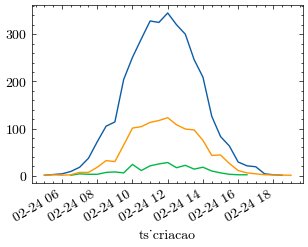

In [332]:
df2.loc[:,'Windows',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
df2.loc[:,'Linux',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
df2.loc[:,'Mac',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
# df2.loc[:,'Windows','Medio','2.1.0']['id_sessao'].plot()
# df2.loc[:,'Windows','Dificil','2.1.0']['id_sessao'].plot()
# plt.legend()